# Proyek Klasifikasi Gambar: Flowers
- **Nama:** Dwi Cahaya Dharma
- **Email:** dwi.dharma@binus.ac.id
- **ID Dicoding:** dwicahaya

## Import Semua Packages/Library yang Digunakan

In [1]:
# Install Google Drive Downloader (GDown) library untuk memungkinkan unduh file dataset langsung dari Google Drive
!pip install gdown

In [2]:
# Install TensorFlow.js versi 4.20.0
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 21.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [3]:
# Import TensorFlow, kemudian periksa versinya apakah sudah versi terbaru atau tidak
import tensorflow as tf
print(tf.__version__)

2.18.0


In [4]:
# Mengecek apakah environment terhubung dengan GPU atau tidak. Tensorflow akan menggunakan CPU apabila environment tidak terhubung dengan GPU
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
  # Menyetel HW accelerator ke GPU apabila environment terhubung dengan GPU
    print("Found GPU at: {}".format(device_name))
else:
  # Menyetel HW accelerator ke CPU apabila environment tidak terhubung dengan GPU
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


In [5]:
# Melakukan importing library-library lain yang diperlukan seperti zipfile, os, pathlib, pandas, numpy, keras, dan matplotlib
import os
import pathlib
import zipfile
from collections import Counter

import tensorflowjs as tfjs

import gdown
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import numpy as np
import pandas as pd
import seaborn as sns

from google.colab import files

## Data Preparation

### Data Loading

In [6]:
# Mengunduh dataset yang sudah digabungkan menjadi satu file .zip dari lima dataset berbeda yang dikumpulkan dari Kaggle
url = "https://drive.google.com/uc?id=1MaQ2tJ7Bi_oRXTXIYaphiSpeo1ovGBhG"
output = "/tmp/flowers_image_dataset.zip"
gdown.download(url, output)

Downloading...
From (original): https://drive.google.com/uc?id=1MaQ2tJ7Bi_oRXTXIYaphiSpeo1ovGBhG
From (redirected): https://drive.google.com/uc?id=1MaQ2tJ7Bi_oRXTXIYaphiSpeo1ovGBhG&confirm=t&uuid=57c5622f-3b87-495a-8735-fc40aecf8562
To: /tmp/flowers_image_dataset.zip
100%|██████████| 610M/610M [00:09<00:00, 64.0MB/s]


'/tmp/flowers_image_dataset.zip'

In [7]:
# Mengekstrak semua dataset yang telah diunduh
local_zip = '/tmp/flowers_image_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [8]:
# Menyiapkan TARGET_SIZE dan BATCH_SIZE
TARGET_SIZE = 160
BATCH_SIZE = 100

# Loading image data
img_dir = '/tmp/flowers_image_data/'

# Inisialisasi label kategori klasifikasi bunga dalam kumpulan list
flowers_label = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Insialisasi variabel 'img_data' dan 'label_name
img_data = []
label_name = []

# Inisialisasi variabel jumlah gambar keseluruhan
total_img = 0

# Mengambil gambar dari setiap kelas
class_counts = {labels: 0 for labels in flowers_label}

for labels in flowers_label:
  category_img_files = os.listdir(img_dir + labels)
  np.random.shuffle(category_img_files)

  # Memeriksa jumlah data gambar pada masing-masing kategori
  print(f"Kategori {labels} memiliki {len(category_img_files)} gambar")

  # Menambahkan ke jumlah data gambar secara total
  total_img += len(category_img_files)

  for img_file in category_img_files:
    img_data.append(os.path.join(img_dir, labels, img_file))
    label_name.append(labels)
    class_counts[labels] += 1

# Insialisasi dataframe untuk dataset sebelum dilakukan balancing
df_before_balancing = pd.DataFrame({'img': img_data, 'label': label_name})

Kategori daisy memiliki 3021 gambar
Kategori dandelion memiliki 3146 gambar
Kategori rose memiliki 2831 gambar
Kategori sunflower memiliki 3097 gambar
Kategori tulip memiliki 3132 gambar


Jumlah data gambar secara keseluruhan sebelum balancing: 15227 gambar


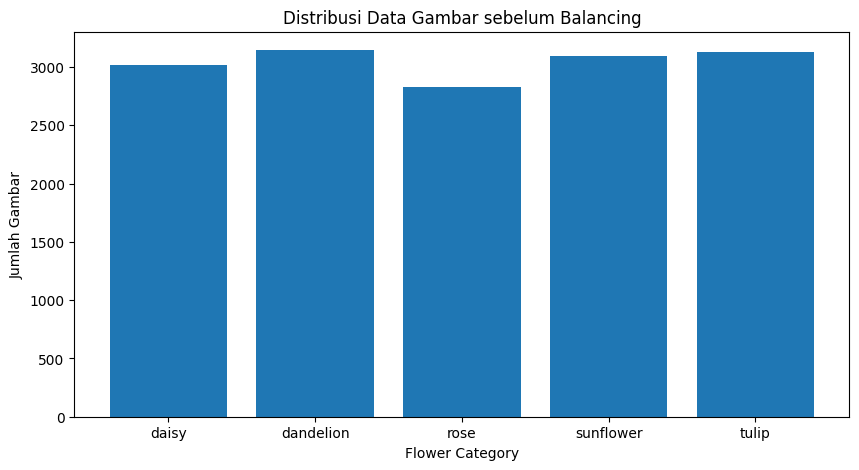

In [9]:
# Menampilkan visualisasi distribusi data gambar pada masing-masing kategori sebelum proses balancing
print(f"Jumlah data gambar secara keseluruhan sebelum balancing: {df_before_balancing['img'].count()} gambar")

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Distribusi Data Gambar sebelum Balancing')
plt.xlabel('Flower Category')
plt.ylabel('Jumlah Gambar')
plt.show()

In [10]:
# Melakukan teknik oversampling untuk menyeimbangkan dataset
MAX_SAMPLES = Counter(label_name).most_common(1)[0][1]

img_data_balanced = []
label_name_balanced = []

for labels in flowers_label:
  indices = [i for i, x in enumerate(label_name) if x == labels]

  NUM_SAMPLES_TO_ADD = MAX_SAMPLES - len(indices)
  INDICES_TO_ADD = np.random.choice(indices, size=NUM_SAMPLES_TO_ADD, replace=True)

  img_data_balanced.extend([img_data[i] for i in INDICES_TO_ADD])
  label_name_balanced.extend([label_name[i] for i in INDICES_TO_ADD])

# Menambahkan data asli ke dalam balanced data list (hasil oversampling)
img_data_balanced.extend(img_data)
label_name_balanced.extend(label_name)

In [11]:
# Membuat dataframe kumpulan keseluruhan gambar dari setiap kategori
df_after_balancing = pd.DataFrame({'img': img_data_balanced, 'label': label_name_balanced})

# Menyimpan 'class_count_balanced' untuk keperluan visualisasi
class_counts_balanced = df_after_balancing['label'].value_counts().to_dict()

Jumlah data gambar secara keseluruhan setelah balancing: 15730 gambar


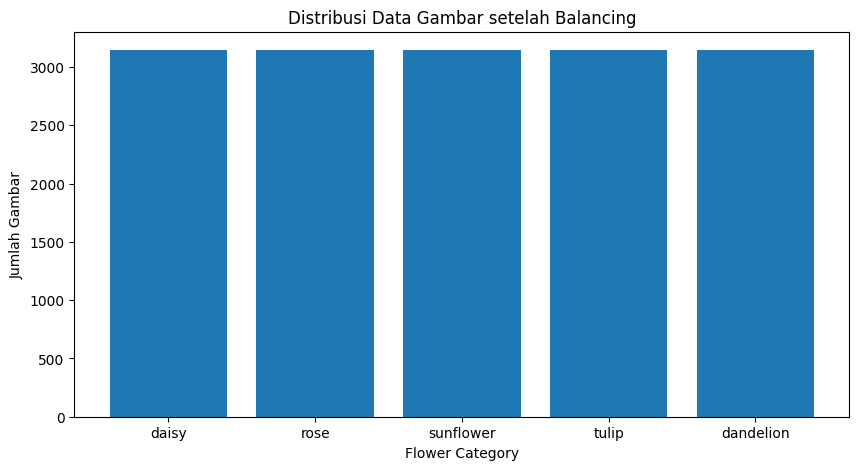

In [12]:
# Menampilkan visualisasi distribusi data gambar pada masing-masing kategori sebelum proses balancing
print(f"Jumlah data gambar secara keseluruhan setelah balancing: {df_after_balancing['img'].count()} gambar")

plt.figure(figsize=(10, 5))
plt.bar(class_counts_balanced.keys(), class_counts_balanced.values())
plt.title('Distribusi Data Gambar setelah Balancing')
plt.xlabel('Flower Category')
plt.ylabel('Jumlah Gambar')
plt.show()

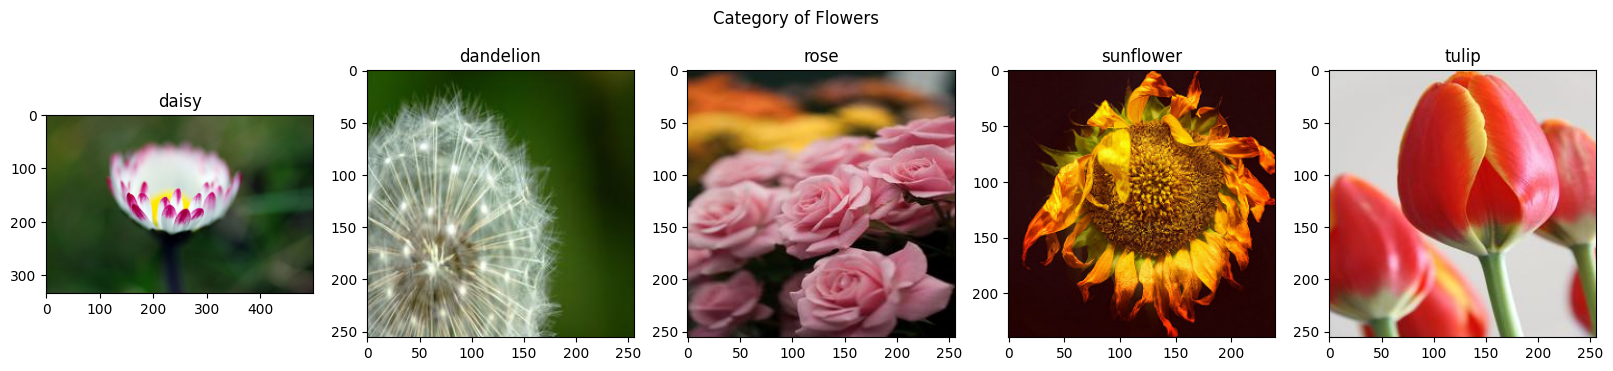

In [13]:
# Memanfaatkan visualisasi data untuk memeriksa isi gambar dari sampel setiap kategori
fig, ax = plt.subplots(ncols=len(flowers_label), figsize=(20, 4))
fig.suptitle('Category of Flowers')

RANDOM_NUM = 12

for i, label in enumerate(flowers_label):
  ax[i].set_title(label)
  ax[i].imshow(plt.imread(df_after_balancing[df_after_balancing['label']==label]['img'].iloc[RANDOM_NUM]))

In [14]:
# Memeriksa image shape sebelum melakukan penyesuaian ukuran gambar
plt.imread(df_after_balancing['img'][0]).shape

(325, 500, 3)

## Data Preprocessing

### Split Dataset

In [15]:
# Mengimpor library untuk keperluan splitting dataset
from sklearn.model_selection import train_test_split

# Inisialisasi variabel X (img) dan Y (label) dari dataframe 'df_after_balancing'
X = df_after_balancing['img']
y = df_after_balancing['label']

In [34]:
# Splitting dataframe ke test data, train data, dan validation data dengan proporsi 70:15:15
# Splitting dataframe ke remaining data dan test data terlebih dahulu dengan proporsi 85:15
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

# Splitting 85% remaining data ke 85% test data dan 15% validation data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1765, #17.65% dari 85% remaining data digunakan sebagai 15% validation data
    rotation_range=20,
    horizontal_flip=True,
    brightness_range=(1.125, 1.50),
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.3,
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1765
)

# Inisialisasi variabel train_img (70% test data), val_img (15% validation data), dan test_img (15% test data)
train_img = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'img': X_train_val, 'label': y_train_val}),
    directory=img_dir,
    x_col='img',
    y_col='label',
    target_size=(TARGET_SIZE, TARGET_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training',
    seed=42
)

val_img = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'img': X_train_val, 'label': y_train_val}),
    directory=img_dir,
    x_col='img',
    y_col='label',
    target_size=(TARGET_SIZE, TARGET_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='validation',
    seed=42
)

test_img = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'img': X_test, 'label': y_test}),
    directory=img_dir,
    x_col='img',
    y_col='label',
    target_size=(TARGET_SIZE, TARGET_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42
)

Found 11011 validated image filenames belonging to 5 classes.
Found 2359 validated image filenames belonging to 5 classes.
Found 2360 validated image filenames belonging to 5 classes.


### Modelling

In [17]:
# Membuat konstanta IMG_SIZE, IMG_SHAPE, NUM_CLASSES, dan EPOCHS
IMG_SIZE = (TARGET_SIZE, TARGET_SIZE)
IMG_SHAPE = IMG_SIZE + (3, )
NUM_CLASSES = len(flowers_label)
EPOCHS = 100

# Membuat model konvolusi sekuensial dengan mengadopsi transfer learning
# Mengadopsi transfer learning MobileNetV2 sebagai 'base_model'
'''Transfer learning MobileNetV2 cocok digunakan dalam klasifikasi gambar bunga, seperti pada project ini.'''
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SHAPE),
    weights='imagenet',
    include_top=False,
    )

# Menonaktifkan semua layer tanpa terkecuali pada transfer learning MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

# Inisialisasi model sekuensial beserta layer pendukungnya
sequential_model = tf.keras.models.Sequential([
    # Input berupa model dari base_model bawaan transfer learning
    base_model,

    # Additional two Conv2D layers and two MaxPooling layers
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), # pooling layer pertama
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), # pooling layer kedua

    # A GlobalAveragePooling layer
    tf.keras.layers.GlobalAveragePooling2D(), # pooling layer ketiga

    # Four additional dense layers
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Membuat kelas 'callback' untuk menghentikan pelatihan apabila akurasi mencapai 96% atau terjadi insignifikansi pada peningkatan akurasi selama 10 kali berturut-turut
class early_stopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.96 and logs.get('val_accuracy')>0.9699):
      print("\nSelamat, akurasi model telah mencapai 96%!")
      self.model.stop_training = True

callbacks = [
        early_stopping(),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('best_sequential_model.keras', monitor='val_loss', save_best_only=True, mode='min')
    ]

# Menampilkan ringkasan struktur arsitektur model transfer learning Xception
base_model.summary()

# Menampilkan ringkasan struktur arsitektur model sekuensial yang telah dibuat
print("\n")
sequential_model.summary()

# Membuat exception untuk mengecek apakah ada file 'best_sequential_model.h5' atau tidak
try:
  sequential_model.load_weights('best_sequential_model.keras')
  print("Weights berhasil dimuat dari file 'best_sequential_model.keras'")
except OSError:
  print("File 'best_sequential_model.keras' tidak ditemukan, memulai pelatihan dari awal...")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 5, 5, 128)           │       1,474,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 5, 5, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 2, 2, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2, 2, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,013,317 (15.31 MB)

 Trainable params: 1,754,949 (6.69 MB)

 Non-trainable params: 2,258,368 (8.61 MB)

File 'best_sequential_model.keras' tidak ditemukan, memulai pelatihan dari awal...


In [18]:
# Menentukan nilai 'steps_per_epoch' dan 'validation_steps' sebagai parameter pelatihan
steps_per_epoch = train_img.samples // BATCH_SIZE
validation_steps = val_img.samples // BATCH_SIZE
test_steps = test_img.samples // BATCH_SIZE

# Melakukan kompilasi model sekuensial yang telah dibuat dengan menyisipkan learning_rate sebesar 0.00001
sequential_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

# Menjalankan pelatihan model sekuensial yang telah dikompilasi
tf.keras.backend.clear_session()
train_history =  sequential_model.fit(
        train_img,
        validation_data=val_img,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 433s 4s/step - accuracy: 0.3089 - loss: 1.5885 - val_accuracy: 0.8443 - val_loss: 0.6236
Epoch 2/100
  1/110 ━━━━━━━━━━━━━━━━━━━━ 6:09 3s/step - accuracy: 0.7400 - loss: 0.7972

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


110/110 ━━━━━━━━━━━━━━━━━━━━ 84s 741ms/step - accuracy: 0.7400 - loss: 0.7972 - val_accuracy: 0.8509 - val_loss: 0.6104
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 504s 4s/step - accuracy: 0.7880 - loss: 0.6353 - val_accuracy: 0.9213 - val_loss: 0.2421
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 78s 701ms/step - accuracy: 0.9100 - loss: 0.2704 - val_accuracy: 0.9235 - val_loss: 0.2397
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 501s 4s/step - accuracy: 0.9041 - loss: 0.3004 - val_accuracy: 0.9287 - val_loss: 0.2229
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 85s 754ms/step - accuracy: 0.9000 - loss: 0.3878 - val_accuracy: 0.9304 - val_loss: 0.2198
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 440s 4s/step - accuracy: 0.9328 - loss: 0.2166 - val_accuracy: 0.9404 - val_loss: 0.1839
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 84s 750ms/step - accuracy: 0.9300 - loss: 0.2953 - val_accuracy: 0.9404 - val_loss: 0.1806
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 467s 4s/step - accuracy: 0.9382 - loss: 0.1978 - val_

### Evaluasi dan Visualisasi

In [19]:
# Menjalankan evaluasi model sekuensial yang telah dibuat menggunakan data pengujian (test data)
eval_history = sequential_model.evaluate(
    test_img,
    steps=test_steps
)

23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.9705 - loss: 0.1039


In [20]:
# Menjalankan prediksi model sekuensial menggunakan data pengujian (test data)
predict_history = sequential_model.predict(
    test_img,
    verbose=0
)
predict_history = predict_history.copy()

In [21]:
# Menyimpan hasil akurasi dan error (loss rate) model ke beberapa variabel
accuracy = train_history.history['accuracy'][-1]
val_accuracy = train_history.history['val_accuracy'][-1]
test_accuracy = eval_history[1]
loss = train_history.history['loss'][-1]
val_loss = train_history.history['val_loss'][-1]
test_loss = eval_history[0]

Accuracy rate: 97.42%
Validation accuracy rate: 95.30%




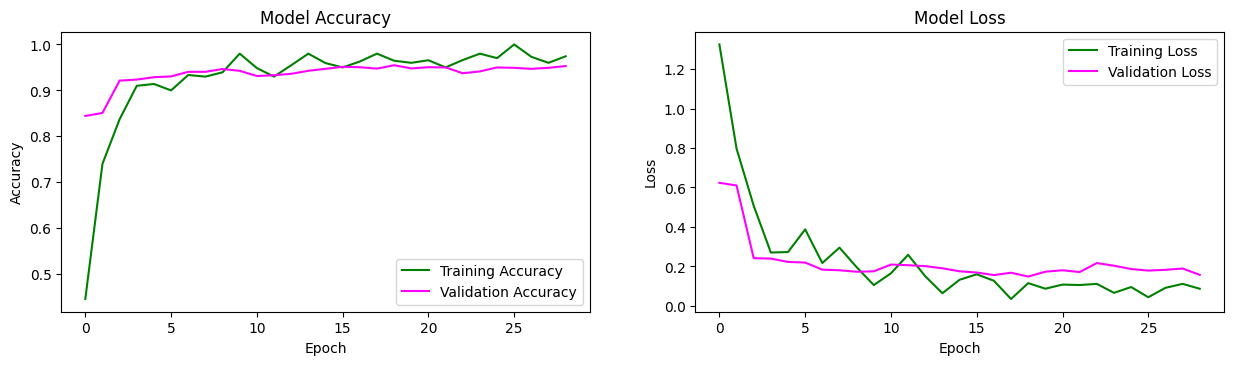

In [22]:
# Memvisualisasikan tingkat akurasi dan loss dari pelatihan model sekuensial
if train_history.history.get('val_loss') != None:
 print(f"Accuracy rate: {accuracy:.2%}")
 print(f"Validation accuracy rate: {val_accuracy:.2%}\n\n")

 plt.figure(1, figsize = (15,8))

 plt.subplot(221)
 plt.plot(train_history.history['accuracy'], color='green')
 plt.plot(train_history.history['val_accuracy'], color='magenta')
 plt.title('Model Accuracy')
 plt.ylabel('Accuracy')
 plt.xlabel('Epoch')
 plt.legend(['Training Accuracy', 'Validation Accuracy'])

 plt.subplot(222)
 plt.plot(train_history.history['loss'], color='green')
 plt.plot(train_history.history['val_loss'], color='magenta')
 plt.title('Model Loss')
 plt.ylabel('Loss')
 plt.xlabel('Epoch')
 plt.legend(['Training Loss', 'Validation Loss'])

 plt.show()

else:
  print("Tidak ada data tersedia untuk dievaluasi...")

Test accuracy rate: 96.78%


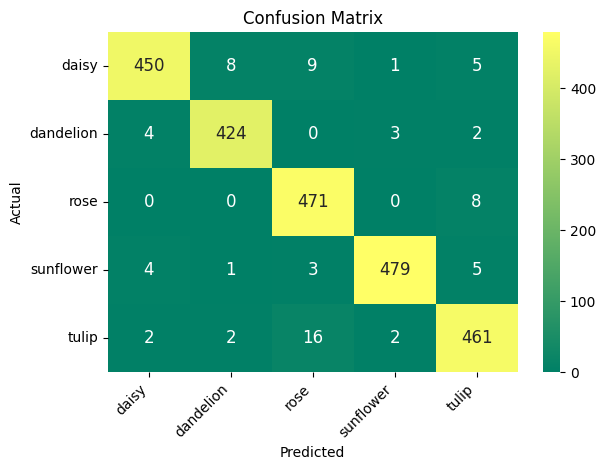


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0     0.9783    0.9514    0.9646       473
           1     0.9747    0.9792    0.9770       433
           2     0.9439    0.9833    0.9632       479
           3     0.9876    0.9736    0.9806       492
           4     0.9584    0.9545    0.9564       483

    accuracy                         0.9682      2360
   macro avg     0.9686    0.9684    0.9684      2360
weighted avg     0.9685    0.9682    0.9682      2360



In [23]:
# Import classification_report library
from sklearn.metrics import confusion_matrix, classification_report

# Membuat variabel 'y_true', 'y_pred', dan 'labels'
y_true = test_img.classes
y_pred = np.argmax(predict_history, axis=1)
labels = flowers_label

unique_labels = np.unique(test_img.classes)
filtered_y_pred = [p for p in y_pred if p in unique_labels]
filtered_y_true = [t for t, p in zip(y_true, y_pred) if p in unique_labels]

# Memvisualisasikan tingkat akurasi dan loss dari pengujian model sekuensial
if test_loss != None:
  print(f"Test accuracy rate: {test_accuracy:.2%}")

  # Menampilkan visualisasi prediksi dalam bentuk confusion matrix
  conf_mat = confusion_matrix(filtered_y_true, filtered_y_pred, labels=unique_labels)
  df_conf_mat = pd.DataFrame(conf_mat, labels, labels)
  sns.heatmap(df_conf_mat, annot=True, annot_kws={"size": 12}, cmap='summer', fmt='d')
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.xticks(rotation=45, ha='right')
  plt.yticks(rotation=0)
  plt.tight_layout()
  plt.show()

  # Menampilkan classification report
  print("\nCLASSIFICATION REPORT\n")
  print(classification_report(y_true, y_pred, digits=4))

else:
  print("Tidak ada data tersedia untuk dievaluasi...")

### Konversi Model

In [26]:
# Menyimpan model dengan SavedModel dalam format .pb
exported_model_dir = '/content/submission/saved_model/'
os.makedirs(exported_model_dir, exist_ok=True)
tf.saved_model.save(sequential_model, exported_model_dir)

In [35]:
# Konversi model ke TensorFlow.js
# Menyiapkan direktori penyimpanan model dalam format TensorFlow JS
exported_tfjs_model_dir = '/content/submission/tfjs_model/'
os.makedirs(exported_tfjs_model_dir, exist_ok=True)

# Menyimpan model dalam format .keras
tfjs_model_path = 'flower_classification_model.h5'
sequential_model.save(tfjs_model_path)

# Konversi model .keras ke model TensorFlow JS
tfjs.converters.save_keras_model(sequential_model, exported_tfjs_model_dir)

failed to lookup keras version from the file,
    this is likely a weight only file


In [36]:
# Konversi model ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model(exported_model_dir)
tflite_model = converter.convert()
open("flower_classification_model.tflite", "wb").write(tflite_model)
# Membuat labels.txt sebagai file tambahan di samping file .tflite
def refactor_labels():
  labels = [folder for folder in os.listdir(img_dir) if not folder.startswith('.')]
  with open('label.txt', 'w') as file:
    for label in labels:
      file.write(label)
      file.write('\n')

refactor_labels()

### Inference (Optional)

Saving sunflower_sample.jpg to sunflower_sample (3).jpg


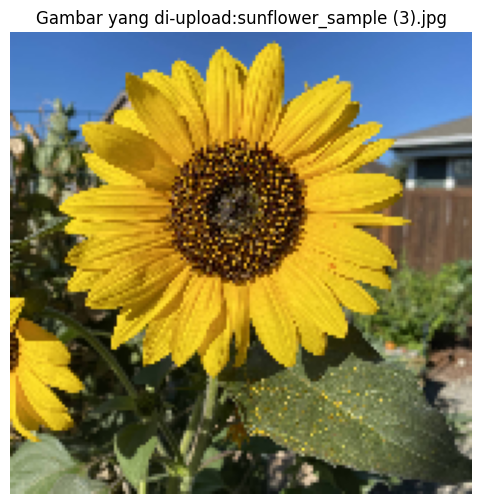

Gambar: sunflower_sample (3).jpg
Diklasifikasikan sebagai: sunflower


In [33]:
# Melakukan inferensi terhadap gambar yang diberikan menggunakan SavedModel
%matplotlib inline

uploaded_img = files.upload()
saved_model_path = '/content/submission/saved_model/'

# Loading file SavedModel
inference_model = tf.saved_model.load(saved_model_path)
inference = inference_model.signatures['serving_default']

# Memprediksi input gambar yang diberikan
for fn in uploaded_img.keys():
  path = fn
  input_img = tf.keras.preprocessing.image.load_img(
      path,
      target_size=(TARGET_SIZE, TARGET_SIZE),
      color_mode='rgb'
  )

  plt.figure(figsize=(6, 6))
  plt.imshow(input_img)
  plt.axis('off')
  plt.title(f'Gambar yang di-upload:{fn}')
  plt.show()

  x = tf.keras.preprocessing.image.img_to_array(input_img)
  x = tf.expand_dims(x, axis=0)

  predictions =inference(tf.constant(x))

  output_tensor = list(predictions.values())[0]
  predicted_class_index = tf.argmax(output_tensor, axis=1).numpy()[0]
  confidence = tf.reduce_max(tf.nn.softmax(output_tensor)).numpy()

  predicted_flower_class = flowers_label[predicted_class_index]
  print(f"Gambar: {fn}")
  print(f"Diklasifikasikan sebagai: {predicted_flower_class}")